#Preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import numpy as np;
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import warnings
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore", category=FutureWarning)
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier,VotingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score,balanced_accuracy_score,roc_auc_score,classification_report
from scipy import stats

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
path="/content/drive/MyDrive/Data mining/"
data= pd.read_csv(path+"data2021.student.csv",index_col="ID")

###Describing the data

In [3]:
data.describe()

,Class,C1,C4,C9,C15,C16,C17,C19,C20,C23,C25,C27,C29,C31,C32
count,1000.00000,1100.000000,1093.000000,1100.000000,1100.0,1100.000000,1100.0,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1094.000000,1100.000000,5.000000
mean,0.27700,34.962727,20.347667,3265.750909,0.0,40530.608182,1.0,5001.148182,2.846364,1.401818,20.308182,2.978182,1.148995,3265.750909,3.000000
std,0.44774,11.345411,12.048965,2833.052110,0.0,28221.725221,0.0,1001.006037,1.104641,0.569466,12.037949,1.113846,0.356246,2833.052110,1.581139
min,0.00000,18.000000,3.000000,249.000000,0.0,1446.000000,1.0,2272.000000,1.000000,1.000000,3.000000,1.000000,1.000000,249.000000,1.000000
25%,0.00000,26.000000,11.000000,1366.000000,0.0,19447.750000,1.0,4326.500000,2.000000,1.000000,11.000000,2.000000,1.000000,1366.000000,2.000000
50%,0.00000,32.000000,18.000000,2301.500000,0.0,33598.000000,1.0,4969.000000,3.000000,1.000000,18.000000,3.000000,1.000000,2301.500000,3.000000
75%,1.00000,41.000000,24.000000,3967.250000,0.0,56142.000000,1.0,5677.000000,4.000000,2.000000,24.000000,4.000000,1.000000,3967.250000,4.000000
max,1.00000,75.000000,72.000000,18424.000000,0.0,220716.000000,1.0,8633.000000,4.000000,4.000000,72.000000,4.000000,2.000000,18424.000000,5.000000


In [4]:
data["Class"]=data["Class"].astype("object")

In [5]:
data.describe(exclude=[np.number])

,Class,C2,C3,C5,C6,C7,C8,C10,C11,C12,C13,C14,C18,C21,C22,C24,C26,C28,C30
count,1000.0,1100,1093,1100,1100,1100,1100,1100,5,1100,1094,1100,1100,1100,1100,1100,1100,1100,1100
unique,2.0,2,5,10,5,4,4,1,3,4,3,4,3,5,2,3,5,4,1
top,0.0,yes,V3,V3,V1,V4,V4,F,V2,V4,V3,V3,V1,V2,V1,V2,V2,V3,T
freq,723.0,1058,370,304,670,437,366,1100,2,437,896,697,997,590,652,779,590,595,1100


###Irrelevant attributes

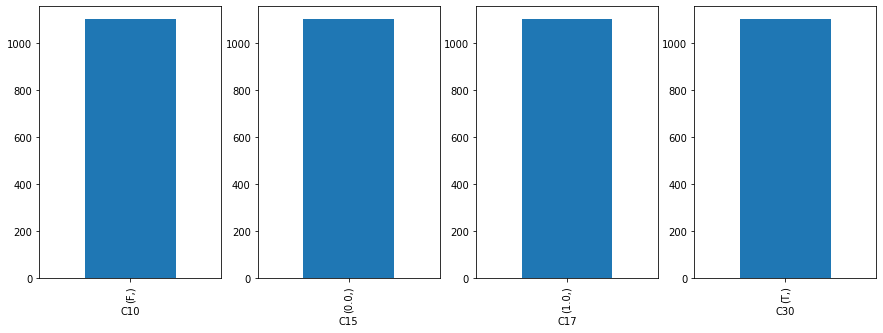

In [6]:
plt.figure(figsize=[15,5])
plt.subplot(1,4,1)
data[["C10"]].value_counts().plot(kind="bar")
plt.subplot(1,4,2)
data[["C15"]].value_counts().plot(kind="bar")
plt.subplot(1,4,3)
data[["C17"]].value_counts().plot(kind="bar")
plt.subplot(1,4,4)
data[["C30"]].value_counts().plot(kind="bar")

In [7]:
def drop_one_unique(_data):
  data=_data.copy()
  decs_cat=data.describe(exclude=[np.number]).T
  col_cat=decs_cat[decs_cat["unique"]==1].index
  data=data.drop(columns=col_cat)
  decs_num=data.describe().T
  col_num=decs_num[decs_num["std"]==0].index
  data=data.drop(columns=col_num)
  return data

In [8]:
data=drop_one_unique(data)

###missing entries

In [9]:
data.columns[data.isna().any()].tolist()[1:]

['C3', 'C4', 'C11', 'C13', 'C29', 'C32']

In [10]:
def drop_most_null(_data,precent=0.5):
  data=_data.copy()
  null_columns=data.columns[data.isna().any()].tolist()[1:]
  for col in null_columns:
    if data[col].isna().sum()>precent*len(data):
      data=data.drop(columns=col)
  return data
data=drop_most_null(data)
data["C3"]=data["C3"].fillna(data["C3"].mode()[0])
data["C4"]=data["C4"].fillna(data["C4"].mean())
data["C13"]=data["C13"].fillna(data["C13"].mode()[0])
data["C29"]=data["C29"].fillna(data["C29"].mode()[0])

### Duplication

In [11]:
def drop_dup(_data):
  data=_data.copy()
  #duplicate row
  data=data.drop_duplicates()
  #duplicate columns
  data=data.T.drop_duplicates().T
  return data

In [12]:
data=drop_dup(data)

In [13]:
#row ID 901-1000 is duplicate with other
data.iloc[899:,:].head()

,Class,C1,C2,C3,C4,C5,C6,C7,C8,C9,C13,C14,C16,C18,C19,C20,C21,C22,C23,C24,C25,C27,C28,C29
ID,,,,,,,,,,,,,,,,,,,,,,,,
900,0,31,yes,V2,18,V3,V1,V4,V4,4594,V3,V3,84949,V1,6939,2,V2,V2,1,V2,18,3,V3,1
1001,NaN,26,yes,V1,23,V10,V1,V4,V3,6314,V1,V4,57966,V2,4909,2,V4,V2,2,V2,23,4,V3,1
1002,NaN,63,yes,V5,60,V9,V1,V1,V3,6836,V3,V3,22076,V1,3840,4,V3,V2,2,V2,60,3,V3,1
1003,NaN,26,yes,V3,35,V3,V1,V3,V4,4209,V3,V3,85811,V1,4317,2,V2,V1,1,V2,35,4,V3,1
1004,NaN,30,yes,V4,5,V3,V1,V1,V4,1956,V3,V3,54301,V1,6171,4,V4,V1,1,V2,5,1,V2,1


###data type

In [14]:
def change_type(_data):
  data=_data.copy()
  cat_col=list(data.describe().T[data.describe().T["unique"]<30].index)
  for i in data.columns:
    if i in cat_col:
      data[i]=data[i].astype("category")
    else:
      data[i]=data[i].astype("int64")
  return data


In [15]:
data=change_type(data)

In [16]:
data.dtypes

Class    category
C1          int64
C2       category
C3       category
C4          int64
C5       category
C6       category
C7       category
C8       category
C9          int64
C13      category
C14      category
C16         int64
C18      category
C19         int64
C20      category
C21      category
C22      category
C23      category
C24      category
C25         int64
C27      category
C28      category
C29      category
dtype: object

### correlation

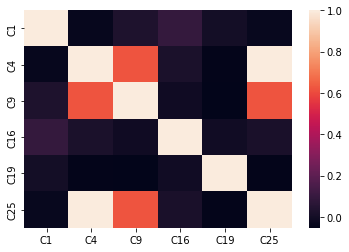

In [17]:
sns.heatmap(data.corr())

In [18]:
data=data.drop(columns=["C25"])

### delete outlier

In [19]:
data=pd.concat([data.loc[data.loc[0:900,["C1","C4","C9","C16","C19"]][(np.abs(stats.zscore(data.loc[0:900,["C1","C4","C9","C16","C19"]].astype("float")))<3).all(axis=1)].index],data.loc[1000:,:]])

In [20]:
data

,Class,C1,C2,C3,C4,C5,C6,C7,C8,C9,C13,C14,C16,C18,C19,C20,C21,C22,C23,C24,C27,C28,C29
ID,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,53,yes,V5,11,V2,V1,V1,V3,7865,V3,V4,30964,V1,3824,4,V2,V2,1,V3,4,V3,1.0
3,1.0,40,yes,V5,18,V2,V1,V2,V3,4296,V3,V4,21999,V1,3720,3,V3,V2,1,V2,4,V1,1.0
4,0.0,28,yes,V3,14,V7,V1,V1,V4,1402,V3,V3,56353,V1,6245,4,V2,V1,1,V1,2,V2,1.0
5,0.0,40,yes,V3,11,V1,V1,V4,V1,1503,V3,V3,6160,V1,5496,4,V3,V1,1,V1,4,V4,1.0
6,0.0,25,yes,V2,11,V3,V1,V2,V1,624,V1,V2,13282,V3,4030,1,V2,V1,1,V2,4,V4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,NaN,31,yes,V3,48,V3,V1,V1,V4,6758,V3,V3,23786,V1,4200,2,V2,V2,1,V2,3,V2,1.0
1097,NaN,39,yes,V5,22,V3,V3,V4,V4,2674,V3,V3,43446,V1,4844,4,V2,V1,1,V2,3,V3,1.0
1098,NaN,23,yes,V3,17,V2,V1,V1,V1,2123,V3,V3,18760,V1,4044,4,V4,V1,2,V1,4,V2,1.0


### Scaling

In [21]:
data[["C1","C4","C9","C16","C19"]]=np.log(data[["C1","C4","C9","C16","C19"]])
scalar=MinMaxScaler()
scalar.fit(data[["C1","C4","C9","C16","C19"]].iloc[:852,:])
data[["C1","C4","C9","C16","C19"]]=scalar.transform(data[["C1","C4","C9","C16","C19"]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b82234e10>,
      dtype=object)

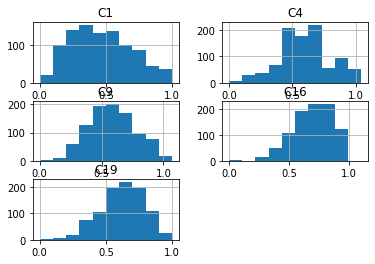

In [22]:
data.hist()

###LabelEncoding

In [23]:
col=['C2', 'C3',  'C5', 'C6', 'C7', 'C8',  'C13','C14', 'C18', 'C20', 'C21', 'C22', 'C23', 'C24','C27', 'C28', 'C29']
for i in col:
  dummies = pd.get_dummies(data.loc[:,i],prefix=i+"_")
  data = pd.concat([data,dummies], axis = 1)
category=data.drop(columns=col).drop(columns=["C1","C4","C9","C16","C19"])

In [24]:
data=pd.concat([category,data[["C1","C4","C9","C16","C19"]]],axis=1)

###train test split

In [25]:
train=data.iloc[:851]
test=data.iloc[851:,1:]

In [26]:
X=train.iloc[:,1:]
y=train.iloc[:,0]

#Classification

###imbalnce data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c186c5110>]],
      dtype=object)

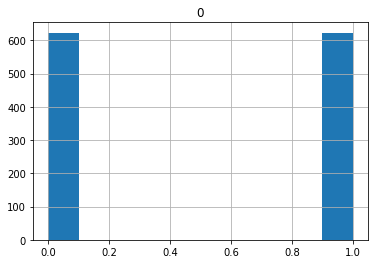

In [ ]:
oversampling=SMOTE()
X_train_oversampling, y_train_oversampling = oversampling.fit_resample(X, y)
pd.DataFrame(y_train_oversampling).hist()

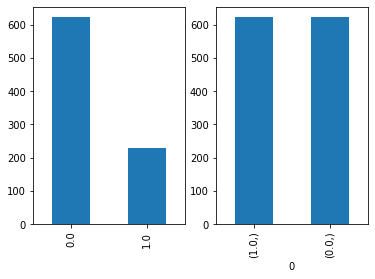

In [ ]:
plt.subplot(1,2,1)
y.value_counts().plot(kind="bar")
plt.subplot(1,2,2)
pd.DataFrame(y_train_oversampling).value_counts().plot(kind="bar")

#GridSearchCV (please ignore this section for quickly predict results)

In [ ]:
model = Pipeline([
        ('oversampling',SMOTE()),   
        ('classification', DecisionTreeClassifier())
    ])
params = {
          'classification__criterion':['gini','entropy']
          ,'classification__max_depth':[4,5,6,7,8,9,10,11,12,15,20]
          }
kfs=StratifiedKFold(n_splits=10,shuffle=True)
grid = GridSearchCV(model, params,cv = kfs,scoring = "balanced_accuracy",verbose=1,n_jobs=-1)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    3.7s


0.6768237878686687
Pipeline(memory=None,
         steps=[('oversampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classification',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=4,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                              

[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    5.2s finished


In [ ]:
model = Pipeline([
        ('oversampling',SMOTE()),         
        ('classification', RandomForestClassifier())
    ])
params = {
          'classification__criterion':['gini','entropy']
          ,'classification__max_depth':[4,5,6,7,8,9,10,11,12,15,20]
          }
kfs=StratifiedKFold(n_splits=10,shuffle=True)
grid = GridSearchCV(model, params,cv = kfs,scoring = "balanced_accuracy",verbose=1,n_jobs=-1)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   52.9s finished


0.6932763317405672
Pipeline(memory=None,
         steps=[('oversampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classification',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=6, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                

In [ ]:
model = Pipeline([
                 ('oversampling',SMOTE()), 
                  ('classification', KNeighborsClassifier())])
params = {'classification__n_neighbors':[1,3,5,7,15,27],
          "classification__p":[1,2,3],
          }
kfs=StratifiedKFold(n_splits=10,shuffle=True)
grid = GridSearchCV(model, params,cv = kfs,scoring = "balanced_accuracy",verbose=1,n_jobs=-1)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    7.6s


0.6753559943251388
Pipeline(memory=None,
         steps=[('oversampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classification',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=27, p=1,
                                      weights='uniform'))],
         verbose=False)
{'classification__n_neighbors': 27, 'classification__p': 1}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   15.9s finished


In [ ]:
model = Pipeline([  
                  ('oversampling',SMOTE()),          
                  ('classification', MultinomialNB())])
params = {
          'classification__alpha': np.logspace(0,-9, num=10)
          }
kfs=StratifiedKFold(n_splits=10,shuffle=True)
grid = GridSearchCV(model, params,cv = kfs,scoring = "balanced_accuracy",verbose=1,n_jobs=-1)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits
0.7012810938477136
Pipeline(memory=None,
         steps=[('oversampling',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('classification',
                 MultinomialNB(alpha=1e-08, class_prior=None, fit_prior=True))],
         verbose=False)
{'classification__alpha': 1e-08}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


#Kfold please (please ignore this section for quickly predict results)

In [ ]:
def do_Kfold(X,y,stratified=True,cv=10,model=["knn","nb","dt","rf"]):
  X=X.reset_index(drop=True)
  y=y.reset_index(drop=True)
  answer={}
  if stratified==True:
    kf=StratifiedKFold(n_splits=cv,shuffle=True)
  else:
    kf=KFold(n_splits=cv,shuffle=True)
  accuracy=[[],[],[],[]]
  f1=[[],[],[],[]]
  auc=[[],[],[],[]]
  m=dict(zip(model,list(range(0,len(model)))))
  for train, validate in kf.split(X, y):
      oversampling = SMOTE()
      X_train_oversampling, y_train_oversampling = oversampling.fit_resample(X.loc[train], y.loc[train])
      for clf in model: 
        if clf=='knn':
          Model=KNeighborsClassifier(n_neighbors=27, p=1)
        elif clf=="nb":
          Model=MultinomialNB(alpha=1e-08)
        elif clf=="dt":
          Model=DecisionTreeClassifier(criterion="gini", max_depth=4)
        elif clf=="rf":
          Model=RandomForestClassifier(criterion="entropy", max_depth=6)
        Model.fit(X_train_oversampling,y_train_oversampling)
        predict_validate = Model.predict(X.loc[validate])
        accuracy[m.get(clf)].append(balanced_accuracy_score(y.loc[validate],predict_validate))
        f1[m.get(clf)].append(f1_score(y.loc[validate],predict_validate))
        auc[m.get(clf)].append(roc_auc_score(y.loc[validate],predict_validate))
  for clf in model:
    answer.update({clf:{"f1":sum(f1[m.get(clf)])/len(f1[m.get(clf)]),"balanced_accuracy":sum(accuracy[m.get(clf)])/len(accuracy[m.get(clf)]),"auc":sum(auc[m.get(clf)])/len(auc[m.get(clf)])}})
  return  answer

In [ ]:
def plot_result(X,y,stratified=True,cv=10,number_run=20,model=["knn","nb","dt","rf"]):
  accuracy=[[],[],[],[]]
  f1=[[],[],[],[]]
  auc=[[],[],[],[]]
  for i in range(0,number_run):
    result=do_Kfold(X,y,stratified=stratified,cv=cv,model=model)
    for j in range(len(model)):
      accuracy[j].append(result.get(model[j]).get("balanced_accuracy"))
      f1[j].append(result.get(model[j]).get("f1"))
      auc[j].append(result.get(model[j]).get("auc"))
  mean_accuracy=np.mean(np.array(accuracy),axis=1)
  mean_f1=np.mean(np.array(f1),axis=1)
  mean_auc=np.mean(np.array(auc),axis=1)
  plt.figure(figsize=[15,5])
  plt.subplot(1,3,1)
  plt.boxplot(accuracy,labels=model)
  plt.title('Balanced accuracy score')
  plt.subplot(1,3,2)
  plt.boxplot(f1,labels=model)
  plt.title('F1 score')
  plt.subplot(1,3,3)
  plt.boxplot(auc,labels=model)
  plt.title('AUC ROC score')
  plt.show()
  return {"Balanced accuracy":dict(zip(model,mean_accuracy)),"F1":dict(zip(model,mean_f1)),"AUC":dict(zip(model,mean_auc))}

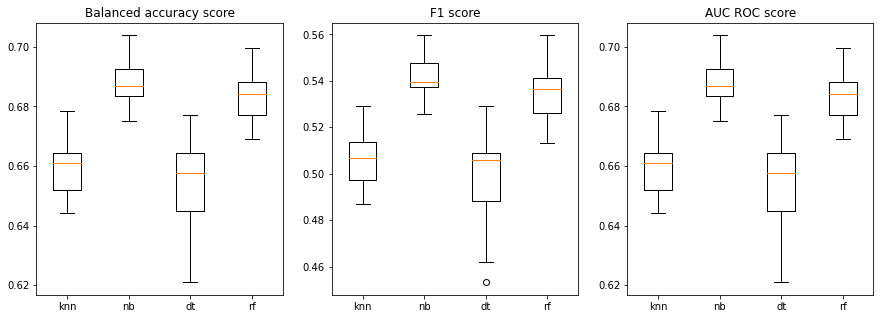

{'AUC': {'dt': 0.653784380065937,
  'knn': 0.6594250458906841,
  'nb': 0.6880735703053376,
  'rf': 0.6830488540989943},
 'Balanced accuracy': {'dt': 0.653784380065937,
  'knn': 0.6594250458906841,
  'nb': 0.6880735703053376,
  'rf': 0.6830488540989943},
 'F1': {'dt': 0.4980081463850232,
  'knn': 0.5065763663764615,
  'nb': 0.5419110978737752,
  'rf': 0.5350349439043071}}

In [ ]:
plot_result(X,y,stratified=True,cv=10,number_run=20,model=["knn","nb","dt","rf"])

#predict unseendata

In [28]:
oversampling = SMOTE(random_state=999)
X_train_oversampling, y_train_oversampling = oversampling.fit_resample(X.values, y.values)
Model1=RandomForestClassifier(criterion="entropy", max_depth=6,random_state=999)
Model2=MultinomialNB(alpha=1e-08)
Model1.fit(X_train_oversampling, y_train_oversampling)
Model2.fit(X_train_oversampling, y_train_oversampling)
y_pred1 = Model1.predict(test)
y_pred2 = Model2.predict(test)

Random Forest

In [ ]:
len(y_pred1[y_pred1==1])

Multinomial

In [ ]:
len(y_pred2[y_pred2==1])

output

In [ ]:
answer=pd.DataFrame(data={"Predict 1":y_pred1,"Predict 2":y_pred2},index=test.index)

In [ ]:
answer.to_csv("/content/drive/MyDrive/Data mining/predict.csv")